# CH. 9 - Hotspot Analysis
## Activities

#### activity 1: one dimensional density estimation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import sklearn.datasets
import sklearn.model_selection
import sklearn.neighbors

seaborn.set()

In [2]:
# randomly generate values
# for which we will estimate a density

rand = numpy.random.RandomState(100)
vals = rand.randn(1000)  # standard normal
vals[375:] += 3.5

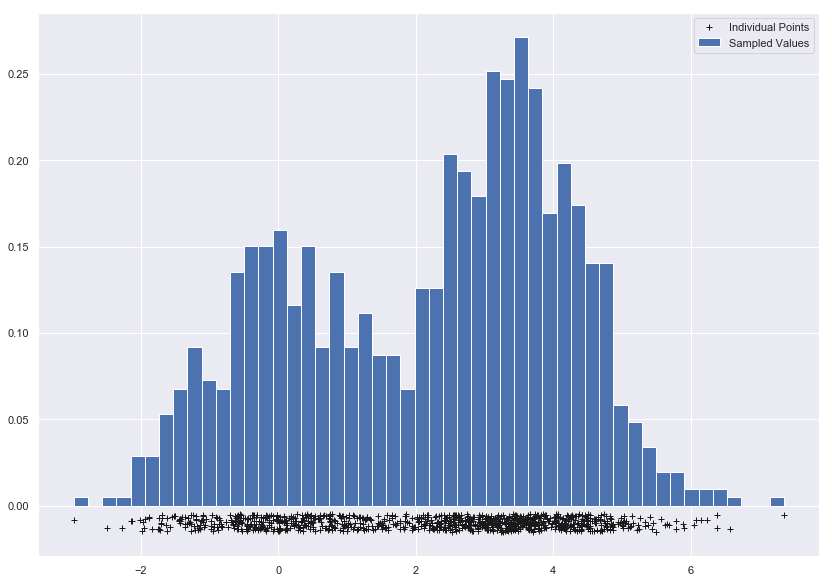

In [3]:
# plot the randomly generated values
# as a histogram

fig, ax = plt.subplots(figsize=(14, 10))
ax.hist(vals, bins=50, density=True, label='Sampled Values')
ax.plot(vals, -0.005 - 0.01 * numpy.random.random(len(vals)), '+k', label='Individual Points')
ax.legend(loc='upper right')

In [4]:
# grid search
# optimal bandwidth value

bandwidths = 10 ** numpy.linspace(-1, 1, 100)

grid = sklearn.model_selection.GridSearchCV(
    estimator=sklearn.neighbors.KernelDensity(kernel="gaussian"),
    param_grid={"bandwidth": bandwidths},
    cv=10
)
grid.fit(vals[:, None])

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [5]:
# extract the optimal bandwidth value

best_bandwidth = grid.best_params_["bandwidth"]

print(
    "Best Bandwidth Value: {}"
    .format(best_bandwidth)
)

Best Bandwidth Value: 0.40370172585965547


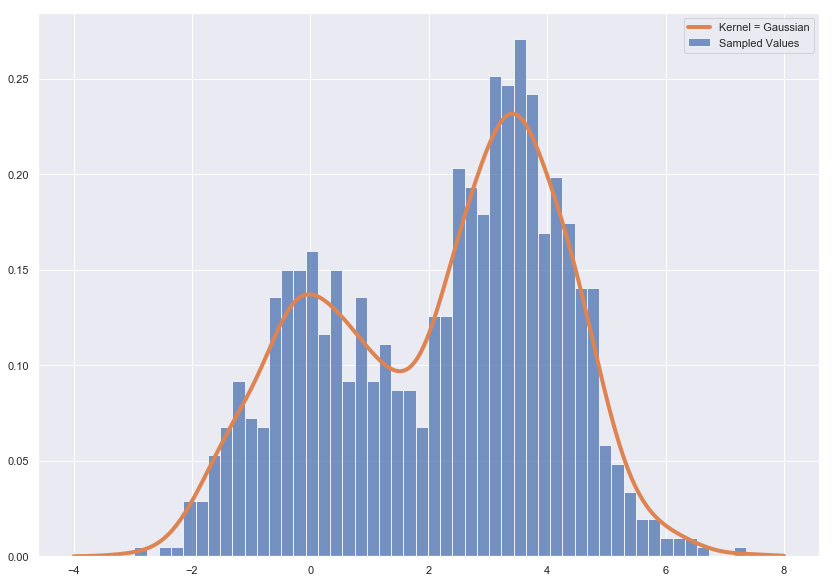

In [6]:
# replot the histogram
# with the optimal estimated density overlayed

fig, ax = plt.subplots(figsize=(14, 10))

ax.hist(vals, bins=50, density=True, alpha=0.75, label='Sampled Values')

x_vec = numpy.linspace(-4, 8, 10000)[:, numpy.newaxis]
log_density = numpy.exp(grid.best_estimator_.score_samples(x_vec))
ax.plot(x_vec[:, 0], log_density, '-', linewidth=4, label='Kernel = Gaussian')

ax.legend(loc='upper right')

#### activity 2: london crime

In [7]:
# define base path

base_path = (
    "~/Documents/packt/unsupervised-learning-python/"
    "chapter-9-hotspot-models/metro-jul18-dec18/"
    "{yr_mon}/{yr_mon}-metropolitan-street.csv"
)

print(base_path)

~/Documents/packt/unsupervised-learning-python/chapter-9-hotspot-models/metro-jul18-dec18/{yr_mon}/{yr_mon}-metropolitan-street.csv


In [8]:
# create the six file tags
# used to load in the data

yearmon_list = [
    "2018-0" + str(i) if i <= 9 else "2018-" + str(i) 
    for i in range(7, 13)
]

print(yearmon_list)

['2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']


In [24]:
# load the data
# print some basic information about the data

data_yearmon_list = []

for idx, i in enumerate(yearmon_list):
    df = pandas.read_csv(
        base_path.format(yr_mon=i), 
        header=0
    )
    
    data_yearmon_list.append(df)
    
    if idx == 0:
        print("Month: {}".format(i))
        print("Dimensions: {}".format(df.shape))
        print("Head:\n{}\n".format(df.head(2)))

Month: 2018-07
Dimensions: (95677, 12)
Head:
                                            Crime ID    Month  \
0  e9fe81ec7a6f5d2a80445f04be3d7e92831dbf3090744e...  2018-07   
1  076b796ba1e1ba3f69c9144e2aa7a7bc85b61d51bf7a59...  2018-07   

                   Reported by                 Falls within  Longitude  \
0  Metropolitan Police Service  Metropolitan Police Service   0.774271   
1  Metropolitan Police Service  Metropolitan Police Service  -1.007293   

    Latitude                    Location  LSOA code            LSOA name  \
0  51.148147  On or near Bethersden Road  E01024031         Ashford 012B   
1  51.893136           On or near Prison  E01017674  Aylesbury Vale 010D   

    Crime type      Last outcome category  Context  
0  Other theft  Status update unavailable      NaN  
1  Other crime     Awaiting court outcome      NaN  



In [12]:
london = pandas.concat(data_yearmon_list)

In [13]:
# perform diagnostics on the
# full concatenated data set

print(
    "Dimensions - Full Data:\n{}\n"
    .format(london.shape)
)
print(
    "Unique Months - Full Data:\n{}\n"
    .format(london["Month"].unique())
)
print(
    "Number of Unique Crime Types - Full Data:\n{}\n"
    .format(london["Crime type"].nunique())
)
print(
    "Unique Crime Types - Full Data:\n{}\n"
    .format(london["Crime type"].unique())
)
print(
    "Count Occurrences Of Each Unique Crime Type - Full Type:\n{}\n"
    .format(london["Crime type"].value_counts())
)

Dimensions - Full Data:
(546032, 12)

Unique Months - Full Data:
['2018-07' '2018-08' '2018-09' '2018-10' '2018-11' '2018-12']

Number of Unique Crime Types - Full Data:
14

Unique Crime Types - Full Data:
['Other theft' 'Other crime' 'Violence and sexual offences'
 'Anti-social behaviour' 'Criminal damage and arson' 'Drugs'
 'Possession of weapons' 'Theft from the person' 'Vehicle crime'
 'Burglary' 'Public order' 'Robbery' 'Shoplifting' 'Bicycle theft']

Count Occurrences Of Each Unique Crime Type - Full Type:
Violence and sexual offences    117499
Anti-social behaviour           115448
Other theft                      61833
Vehicle crime                    58857
Burglary                         41145
Criminal damage and arson        28436
Public order                     24655
Theft from the person            22670
Shoplifting                      21296
Drugs                            17292
Robbery                          17060
Bicycle theft                    11362
Other crime   

In [14]:
# filter the data down

london_subset = london[["Month", "Longitude", "Latitude", "Crime type"]]
london_subset.head(5)

,Month,Longitude,Latitude,Crime type
0,2018-07,0.774271,51.148147,Other theft
1,2018-07,-1.007293,51.893136,Other crime
2,2018-07,0.744706,52.038219,Violence and sexual offences
3,2018-07,0.148434,51.595164,Anti-social behaviour
4,2018-07,0.137065,51.583672,Anti-social behaviour


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


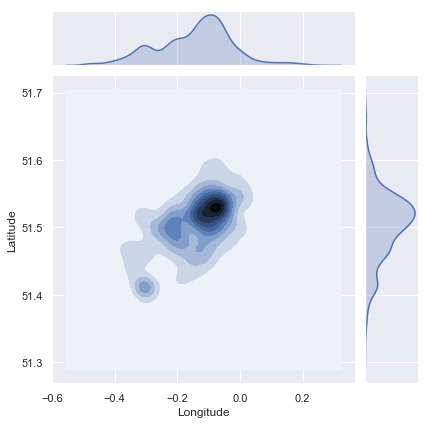

In [15]:
# plotting bicycle theft
# for three randomly selected months

crime_bicycle_jul = london_subset[
    (london_subset["Crime type"] == "Bicycle theft") & 
    (london_subset["Month"] == "2018-07")
]

seaborn.jointplot("Longitude", "Latitude", crime_bicycle_jul, kind="kde")

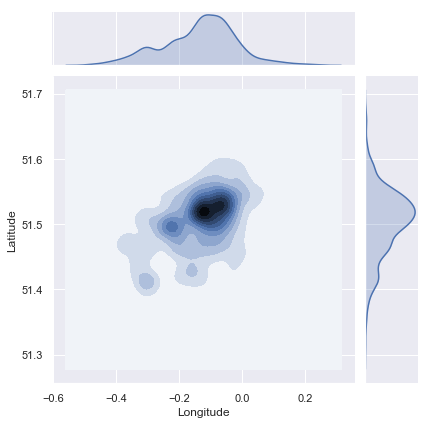

In [16]:
crime_bicycle_sept = london_subset[
    (london_subset["Crime type"] == "Bicycle theft") & 
    (london_subset["Month"] == "2018-09")
]

seaborn.jointplot("Longitude", "Latitude", crime_bicycle_sept, kind="kde")

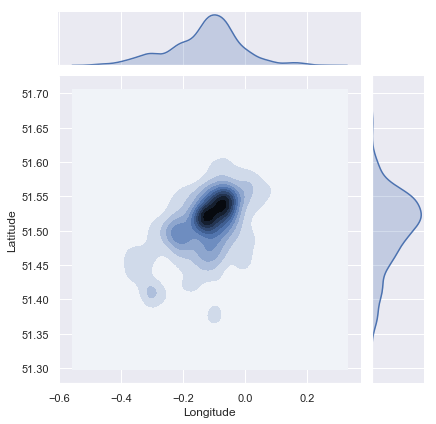

In [17]:
crime_bicycle_dec = london_subset[
    (london_subset["Crime type"] == "Bicycle theft") & 
    (london_subset["Month"] == "2018-12")
]

seaborn.jointplot("Longitude", "Latitude", crime_bicycle_dec, kind="kde")

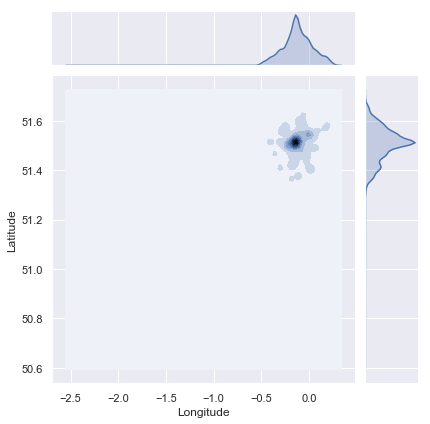

In [18]:
# plotting shoplifting
# for three randomly selected months

crime_shoplift_aug = london_subset[
    (london_subset["Crime type"] == "Shoplifting") & 
    (london_subset["Month"] == "2018-08")
]

seaborn.jointplot("Longitude", "Latitude", crime_shoplift_aug, kind="kde")

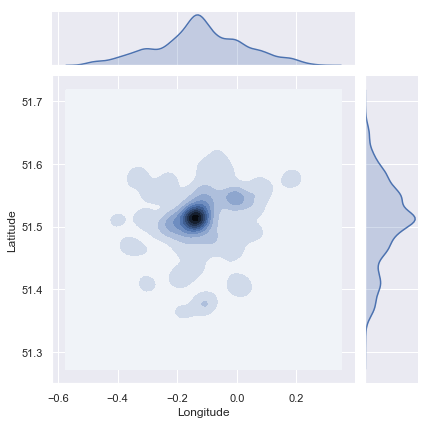

In [19]:
crime_shoplift_oct = london_subset[
    (london_subset["Crime type"] == "Shoplifting") & 
    (london_subset["Month"] == "2018-10")
]

seaborn.jointplot("Longitude", "Latitude", crime_shoplift_oct, kind="kde")

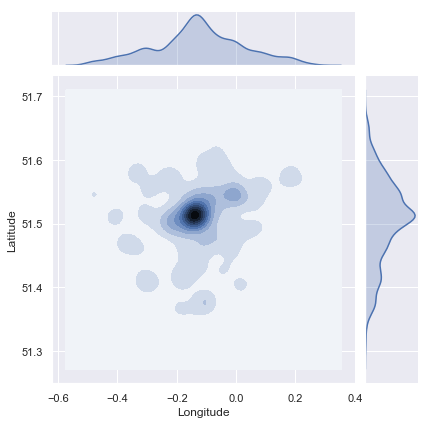

In [20]:
crime_shoplift_nov = london_subset[
    (london_subset["Crime type"] == "Shoplifting") & 
    (london_subset["Month"] == "2018-11")
]

seaborn.jointplot("Longitude", "Latitude", crime_shoplift_nov, kind="kde")

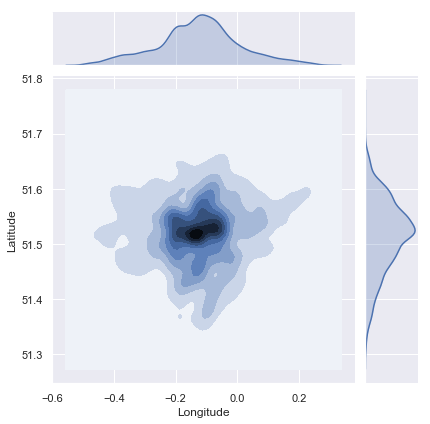

In [21]:
# plotting burglary
# for three randomly selected months

crime_burglary_jul = london_subset[
    (london_subset["Crime type"] == "Burglary") & 
    (london_subset["Month"] == "2018-07")
]

seaborn.jointplot("Longitude", "Latitude", crime_burglary_jul, kind="kde")

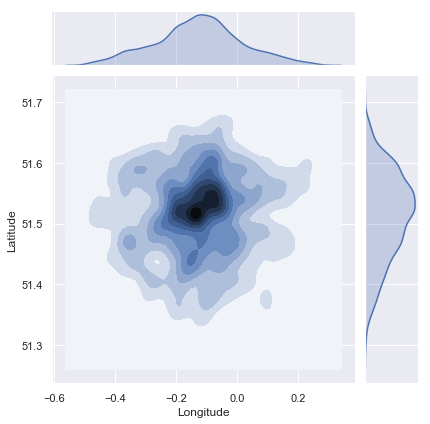

In [22]:
crime_burglary_oct = london_subset[
    (london_subset["Crime type"] == "Burglary") & 
    (london_subset["Month"] == "2018-10")
]

seaborn.jointplot("Longitude", "Latitude", crime_burglary_oct, kind="kde")

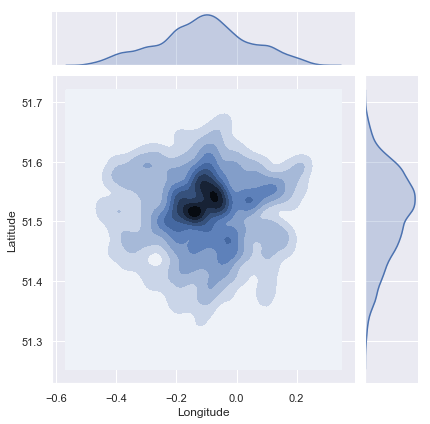

In [23]:
crime_burglary_dec = london_subset[
    (london_subset["Crime type"] == "Burglary") & 
    (london_subset["Month"] == "2018-12")
]

seaborn.jointplot("Longitude", "Latitude", crime_burglary_dec, kind="kde")